# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [57]:

### Your code implementation goes here.
### Feel free to use as many code cells as needed.


In [1]:
""" Modules """

from __future__ import print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
import sys
import tarfile
import gzip
import idx2numpy
import tensorflow as tf
import time
import glob
import h5py

#from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from array import array as pyarray
from PIL import Image

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the MNIST data set to local machine from links provided [here](http://yann.lecun.com/exdb/mnist/).

Contains a training set of 60,000 examples, and a test set of 10,000 handwritten digits that have been size-normalized and centered in a fixed-size image.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

In [4]:
""" Import the MNIST Data """
url = 'http://yann.lecun.com/exdb/mnist/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. 
    Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if expected_bytes == None:
        print('Found', filename, 'but no size to verify against')
    elif statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [3]:
train_images_filename = maybe_download('train-images-idx3-ubyte.gz', 9912422)
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz', 28881)
test_images_filename  = maybe_download('t10k-images-idx3-ubyte.gz', 1648877)
test_labels_filename  = maybe_download('t10k-labels-idx1-ubyte.gz', 4542)

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


Extract the dataset from the compressed .gz files.

In [38]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .gz
    # extract data
    if os.path.isfile(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        inF = gzip.GzipFile(filename, 'rb')
        s = inF.read()
        inF.close()

        outF = open(root, 'wb')
        outF.write(s)
        outF.close()
    # Return as numpy array
    f = open(root, 'rb')
    if 'images' in root:
        x = idx2numpy.convert_from_file(f)
        f.close()

    elif 'labels' in root:
        magic_nr, size = struct.unpack(">II", f.read(8))
        x = pyarray("b", f.read())
        f.close()

    return np.array(x)

train_images = maybe_extract(train_images_filename)
train_labels = maybe_extract(train_labels_filename)
test_images  = maybe_extract(test_images_filename)
test_labels  = maybe_extract(test_labels_filename)

print ("\nDimension check...")
print ("\t training labels:", train_labels.shape)
print ("\t training images:", train_images.shape)
print ("\t test set labels:", test_labels.shape)
print ("\t test set labels:", test_images.shape)

train-images-idx3-ubyte already present - Skipping extraction of train-images-idx3-ubyte.gz.
train-labels-idx1-ubyte already present - Skipping extraction of train-labels-idx1-ubyte.gz.
t10k-images-idx3-ubyte already present - Skipping extraction of t10k-images-idx3-ubyte.gz.
t10k-labels-idx1-ubyte already present - Skipping extraction of t10k-labels-idx1-ubyte.gz.

Dimension check...
	 training labels: (60000,)
	 training images: (60000, 28, 28)
	 test set labels: (10000,)
	 test set labels: (10000, 28, 28)


Examine a few images to make sure that it's sensible.

In [2]:
def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()

In [ ]:
for i in xrange(5):
    print("Image below should be a", train_labels[i])
    show(train_images[i])

We also want to make sure that the image values are normalized (to suit to DNN).

Currently, the range of values are:

In [39]:
train_images.min(),train_images.max()

(0, 255)

We'll normalize them to a range of 0 to 1, which is suitable for hidden relu layers.

Aside, this is in contrast to activation functions like `tanh` are used, which would better suit a range of -.5 to .5

New min and max: 0.0 1.0


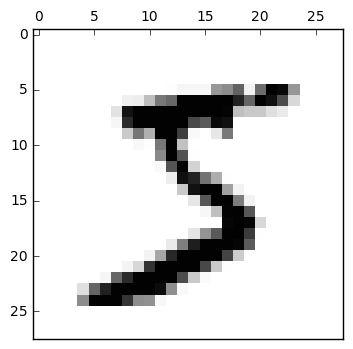

In [41]:
pixel_max = float(train_images.max())

train_images = train_images / pixel_max
test_images  = test_images / pixel_max

# Check images are still legit:
print("New min and max:", train_images.min(),train_images.max())

show(train_images[0])

We need to create synthetic combinations of these images. Eg., up to five images combined at a time.

This section will create training and test sets of these synthetic sequences.

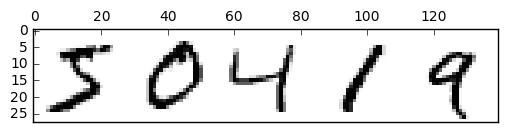

In [42]:
# Using numpy.hstack will stack together the pixel arrays to form synthetic sequences.
# Example:
show(np.hstack(train_images[:5]))

So we will need to create a random (ideally reproducible) set of these sequences up to length 5.

We also need to handle sequences of varying lengths.

The image below should show [ 4  4  5 -1 -1]


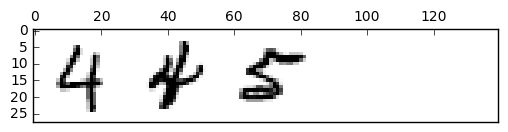

The image below should show [4 2 7 7 1]


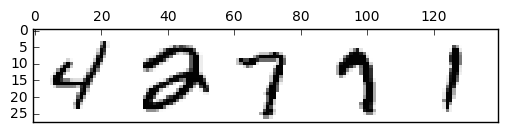

The image below should show [ 8 -1 -1 -1 -1]


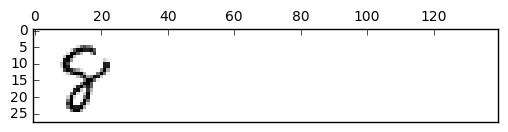

In [43]:
# Define maximum sequence length
seq_max_n = 5

# Define the number of training, validation, and test sequences to create
n_train_seq = 100000
n_valid_seq =  30000  # Note - these will come from test data
n_test_seq  =  30000

# Create max-length sequences as an array of references to single digits
np.random.seed(seed=345)
train_seq = np.random.randint(len(train_images), size=[n_train_seq, seq_max_n])
valid_seq = np.random.randint(len(test_images), size=[n_valid_seq, seq_max_n])
test_seq  = np.random.randint(len(test_images),  size=[n_test_seq, seq_max_n])

# Generate sequence lengths (1 - seq_max_n)
np.random.seed(seed=54)
train_seq_n = np.random.randint(seq_max_n, size=n_train_seq) + 1
valid_seq_n = np.random.randint(seq_max_n, size=n_valid_seq) + 1
test_seq_n  = np.random.randint(seq_max_n, size=n_test_seq) + 1

# Define a no-digit matrix of zeros and append as last item in image sets
# Label for this is -1
no_digit_array = [np.zeros(train_images[0].shape)]
train_images=np.append(train_images, no_digit_array, axis=0)
test_images=np.append(test_images, no_digit_array, axis=0)
train_labels=np.append(train_labels, -1)
test_labels=np.append(test_labels, -1)

# Reference 'no_digit' beyond allocated sequence length

''' Substitute in no-digit matrices beyond allocated sequence length '''
def no_digit_sub(seq, seq_n, seq_max_n = seq_max_n):
    if seq_n < seq_max_n:
        to_zero = range(seq_n, seq_max_n)
        for z in to_zero:
            # Nb, this -1 references last item in array
            # Not to be confused with -1 label above
            seq[z] = -1
    
for i, n in enumerate(train_seq_n):
    no_digit_sub(train_seq[i], n)
    
for i, n in enumerate(valid_seq_n):
    no_digit_sub(valid_seq[i], n)
    
for i, n in enumerate(test_seq_n):
    no_digit_sub(test_seq[i], n)

print ("The image below should show", train_labels[train_seq[0]])
show(np.hstack(train_images[train_seq[0]]))

print ("The image below should show", test_labels[valid_seq[0]])
show(np.hstack(test_images[valid_seq[0]]))

print ("The image below should show", test_labels[test_seq[0]])
show(np.hstack(test_images[test_seq[0]]))

Above, we created an array of length-5 arrays. Each length-5 array contains index references to single digits.

The images above are created by combining these references. However, we need to store these as single images to operate on.

Final image array shapes...
train	 (100000, 28, 140)
valid	 (30000, 28, 140)
test	 (30000, 28, 140)

The image below should show [ 4  4  5 -1 -1]


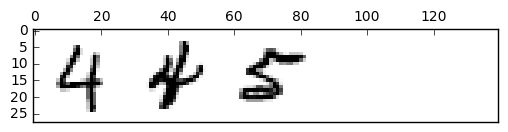

The image below should show [4 2 7 7 1]


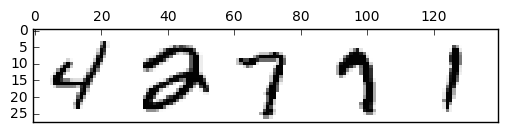

The image below should show [ 8 -1 -1 -1 -1]


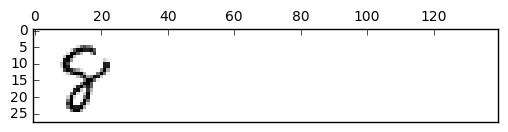

In [46]:
# Initialize final train, valid, and test sets of images:
train = np.empty(np.append(n_train_seq, np.hstack(train_images[train_seq[0]]).shape), dtype=float)
valid = np.empty(np.append(n_valid_seq, np.hstack(test_images[valid_seq[0]]).shape), dtype=float)
test  = np.empty(np.append(n_test_seq, np.hstack(test_images[test_seq[0]]).shape), dtype=float)

train_l = np.empty(np.append(n_train_seq, seq_max_n), dtype=int)
valid_l = np.empty(np.append(n_valid_seq, seq_max_n), dtype=int)
test_l  = np.empty(np.append(n_test_seq, seq_max_n), dtype=int)

print("Final image array shapes...")
print('train\t', train.shape)
print('valid\t', valid.shape)
print('test\t', test.shape)

# Fill in these arrays with stacked images
for i, s in enumerate(train_seq):
    train[i] = np.hstack(train_images[s])
    train_l[i] = train_labels[s]

for i, s in enumerate(valid_seq):
    valid[i] = np.hstack(test_images[s])
    valid_l[i] = test_labels[s]

for i, s in enumerate(test_seq):
    test[i] = np.hstack(test_images[s])
    test_l[i] = test_labels[s]

print()
# Tests...
print ("The image below should show", train_l[0])
show(train[0])

print ("The image below should show", valid_l[0])
show(valid[0])

print ("The image below should show", test_l[0])
show(test[0])

We now have to get data into shape suitable for convolution network...

In [47]:
img_height = train[0].shape[0]
img_width  = train[0].shape[1]
num_labels = 11  # -1 to 9
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, img_width, img_height, num_channels)).astype(np.float32)
    labels = ((np.arange(num_labels) - 1) == labels[:,:,None]).astype(np.float32)
    return dataset, labels

train, train_l = reformat(train, train_l)
valid, valid_l = reformat(valid, valid_l)
test, test_l   = reformat(test, test_l)
print('Training set', train.shape, train_l.shape)
print('Validation set', valid.shape, valid_l.shape)
print('Test set', test.shape, test_l.shape)

Training set (100000, 140, 28, 1) (100000, 5, 11)
Validation set (30000, 140, 28, 1) (30000, 5, 11)
Test set (30000, 140, 28, 1) (30000, 5, 11)


Notice in the above that the labels have been one-hot encoded as 2D vectors, which provide location on axis 0 and value information on axis 1.

For example...

In [48]:
print(train_l[0])  # Should correspond to 4,4,5 shown above (trailed by -1,-1)

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


We now have our images and labels in reasonable shape.

Time to implement our DNN. We'll start with convoluation layers feeding into 5 logit classifiers.

In [49]:
# Function to determine prediction accuracy
def accuracy(predictions, labels):
    return(100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))
          / predictions.shape[0] / predictions.shape[1])

In [63]:
batch_size = 128
patch_size = 5

# Conv depths...
depth1 = 16
depth2 = 32
depth3 = 64

# Hidden depths...
n_hidden1 = 128
n_hidden2 = 64

graph = tf.Graph()

with graph.as_default():
    
    # Input data -----------------------
    tf_train = tf.placeholder(
        tf.float32, shape = (batch_size, img_width, img_height, num_channels)
    )
    tf_train_l = tf.placeholder(
        tf.float32, shape = (batch_size, svhn_max_digits, num_labels)
    )
    tf_valid = tf.constant(valid)
    tf_test  = tf.constant(test)
    
    # Net parameters -----------------------
    
    ## TODO: create wrapper function to initialize weights and biases
    
    # Convolution layers
    c1_w = tf.Variable(
        # truncated_normal good to avoid vanishing gradient; set stdev to something small (.05)
        # don't use 'random'
        # Deep Learning researcher - Yoshua Bengio
        # Tensorflow has Xavier initialization scheme to help optimize weight initialization
        # Supports quicker learning and avoid vanishing gradient
        # Contrib layers in tensorflow
        tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev = 0.05)
    )
    c1_b = tf.Variable(
        tf.zeros([depth1])
    )
    c2_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev = 0.05)
    )
    c2_b = tf.Variable(
        tf.constant(1.0, shape = [depth2])
    )
    c3_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev = 0.05)
    )
    c3_b = tf.Variable(
        tf.constant(1.0, shape = [depth3])
    )
    # Fully connected layers
    f1_w = tf.Variable(
        tf.truncated_normal([depth3*3, n_hidden1], stddev = 0.05)
    )
    f1_b = tf.constant(1.0, shape = [n_hidden1])
    f2_w = tf.Variable(
        tf.truncated_normal([n_hidden1, n_hidden2], stddev = 0.05)
    )
    f2_b = tf.constant(1.0, shape = [n_hidden2])
    
    
    # Logistic classifier layers (one for each digit)
    s1_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s1_b = tf.constant(1.0, shape = [num_labels])
    s2_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s2_b = tf.constant(1.0, shape = [num_labels])
    s3_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s3_b = tf.constant(1.0, shape = [num_labels])
    s4_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s4_b = tf.constant(1.0, shape = [num_labels])
    s5_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s5_b = tf.constant(1.0, shape = [num_labels])
    
    # Model ----------------------
    
    # Convolution wrapper
    # - Can move this (and others) to external python file with required libraries and import
    def conv2d(X, W, b):
        conv = tf.nn.conv2d(X, W, strides = [1, 2, 2, 1], padding = 'SAME') + b
        # Order (1) pool then (2) hidden reduces computation requirements and speeds learning
        pool = tf.nn.max_pool(conv, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        hidden = tf.nn.relu(pool)
        return hidden
    
    # Model
    def model(data, keep_prob = 1):
        # Convolution layers
        x = conv2d(data, c1_w, c1_b)
        x = conv2d(x,    c2_w, c2_b)
        x = conv2d(x,    c3_w, c3_b)
        
        # Fully connected
        shape = x.get_shape().as_list()  ## TODO: lookup tf.flatten to handle this MUCH faster (in C++)
        reshape = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(reshape, f1_w) + f1_b)
        x = tf.nn.relu(tf.matmul(x, f2_w) + f2_b)
        x = tf.nn.dropout(x, keep_prob)
        
        # Logistic classifiers for each digit
        logit1 = tf.matmul(x, s1_w) + s1_b
        logit2 = tf.matmul(x, s2_w) + s2_b
        logit3 = tf.matmul(x, s3_w) + s3_b
        logit4 = tf.matmul(x, s4_w) + s4_b
        logit5 = tf.matmul(x, s5_w) + s5_b
        
        # Combine predictions to match 2D encoding
        # Note. if using sparse_... need pack([]), but not `axis=1`
        pred = tf.pack([logit1, logit2, logit3, logit4, logit5], axis=1)
        print(pred)
        return(pred)

    # Run --------------------------
    # If model seems to be overfitting, look at:
    # l1 and l2 regularisers; batch normalization
    
    logits = model(tf_train, 0.50)  # Drop out - .75 too high. Try not to exceed .50
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 0, :], tf_train_l[:, 0])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 1, :], tf_train_l[:, 1])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 2, :], tf_train_l[:, 2])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 3, :], tf_train_l[:, 3])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 4, :], tf_train_l[:, 4]))
    
    ## TODO: examine Adam optimizer (has a self adjusting learning rate)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    train_pred = tf.nn.softmax(logits)
    valid_pred = tf.nn.softmax(model(tf_valid))
    test_pred  = tf.nn.softmax(model(tf_test))

Tensor("pack:0", shape=(128, 5, 11), dtype=float32)
Tensor("pack_1:0", shape=(30000, 5, 11), dtype=float32)
Tensor("pack_2:0", shape=(30000, 5, 11), dtype=float32)


In [79]:
""" Run the graph """
num_steps = 1000001
start_time = time.time()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Intialized\n")
    
    for step in range(num_steps):
        offset  = (step * batch_size) % (train_l.shape[0] - batch_size)
        batch   = train[offset:(offset + batch_size), :, :, :]
        batch_l = train_l[offset:(offset + batch_size), :]
        feed_dict = {
            tf_train   : batch,
            tf_train_l : batch_l
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_pred], feed_dict = feed_dict
        )
        
        if (step % 1000 == 0):
            print('--- Step %d ---' % (step))
            print('Time elapsed: %.1f seconds' % (time.time() - start_time))
            print('Minibatch loss: %f' % (l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_l))
            print('Validation accuracy: %.1f%%' % accuracy(valid_pred.eval(), valid_l))
            print()
    
    print('--- Test ---')
    print('Test accuracy: %.1f%%' % accuracy(test_pred.eval(), test_l))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Intialized

--- Step 0 ---
Time elapsed: 4.4 seconds
Minibatch loss: 13.666569
Minibatch accuracy: 6.7%
Validation accuracy: 6.1%

--- Step 1000 ---
Time elapsed: 120.6 seconds
Minibatch loss: 6.869938
Minibatch accuracy: 51.2%
Validation accuracy: 50.3%

--- Step 2000 ---
Time elapsed: 231.2 seconds
Minibatch loss: 6.398312
Minibatch accuracy: 55.6%
Validation accuracy: 54.5%

--- Step 3000 ---
Time elapsed: 340.6 seconds
Minibatch loss: 6.349179
Minibatch accuracy: 51.6%
Validation accuracy: 57.5%

--- Step 4000 ---
Time elapsed: 450.8 seconds
Minibatch loss: 6.066477
Minibatch accuracy: 57.2%
Validation accuracy: 59.1%

--- Step 5000 ---
Time elapsed: 561.2 seconds
Minibatch loss: 5.937634
Minibatch accuracy: 55.5%
Validation accuracy: 60.3%

--- Step 6000 ---
Time elapsed: 670.1 seconds
Minibatch loss: 5.629911
Minibatch accuracy: 59.8%
Validation accuracy: 61.3%

--- Step 7000 ---
Time elapsed: 779.3 seconds

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

I knew I wanted to use a convolution neural net, because convolutions are well suited to detecting objects in images. This will become especially important in the subsequent portions of this project, where the numbers can appear in any part of the image, at any angle/rotation, etc.

My final convolution architecture (described in following section) was based on previously successful designs. To quickly summarise, the convolution layers increase the input depth, enabling detection of objects across the image, and then fully connected layers handle the learning.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

My final architecture involves convoluations and fully connected layers. It can be summarised as:

- 3 x convolution layers with max pooling and relu activation; depth increases with each additional layer.
- 2 x fully connected layers with relu activation; relu numbers decrease with each additional layer.
- Drop out is applied.
- 5 x ordered logistic classifiers trained on five ordered input labels.


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

Training was achieved using stochastic gradient descent: training on small, random samples of the data. Loss was summed across the five logistic classifiers.

The samples used for training came from a synthetic dataset of images including one to five numbers, that was constructed using the MNIST dataset. Images in the synthetic datatset were constructed as follows:

- Randomly sample five images from MNIST (five being the maximum allowable sequence length).
- Randomly sample a sequence length of 1 to 5.
- For sequence lengths `n` that were less than 5, replace the last `5 - n` images with blank regions and label them `-1`.

This process was done to create 100000 sequences for training data, and 30000 for validation and 30000 for test data.

Many examples are shown above. Here is another:

The image below should show [ 0  0  7  9 -1]


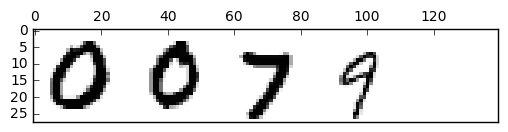

In [82]:
print ("The image below should show", train_labels[train_seq[100]])
show(np.hstack(train_images[train_seq[100]]))

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



Importing the Street View House Numbers (SVNH) datasets...

In [5]:
""" Import the SVNH Data """
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

train_svnh_filename = maybe_download('train.tar.gz', None)
test_svnh_filename  = maybe_download('test.tar.gz', None)

Found train.tar.gz but no size to verify against
Found test.tar.gz but no size to verify against


In [6]:
def maybe_extract_svnh(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    # extract data
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        
    return root

train_svnh_folder = maybe_extract_svnh(train_svnh_filename)
test_svnh_folder = maybe_extract_svnh(test_svnh_filename)    

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


The downloaded datasets are stored in two folders. Each folder contains the relevant .png files and a digitStruct.mat file containing labels and bounding box information. We'll convert these to useable numpy arrays...

In [7]:
'''
SUPPORT FUNCTIONS
Ref: https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657
'''

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

def digitStructMatAsList(directory):
    fin = os.path.join(directory, 'digitStruct.mat')
    dsf = DigitStructFile(fin)
    return dsf.getAllDigitStructure_ByDigit()

In [8]:
# Get all .mat file information into lists
# - Takes some time
train_svhn_data = digitStructMatAsList(train_svnh_folder)
test_svhn_data  = digitStructMatAsList(test_svnh_folder)

In [9]:
""" Data check """
print('Example filename\n\t', train_svhn_data[0]['filename'])
eg_box = train_svhn_data[0]['boxes']
print('Example box information with', len(eg_box), 'digits\n\t', eg_box)

Example filename
	 1.png
Example box information with 2 digits
	 [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}]


In [21]:
"""
Create greyscale `.thumbnail` versions of all images.
This means all images will have same dimensions and a depth of 1

References:
    http://pillow.readthedocs.io/en/3.1.x/reference/Image.html
    http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    http://stackoverflow.com/questions/14177744/how-does-perspective-transformation-work-in-pil
"""

# Size to convert all images to for learning!
size = 64, 64

''' Find coefficients '''
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)



In [186]:
for infile in glob.glob(train_svnh_folder + "/*.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert('L')
    
    width, height = im.size
    new_width, new_height = size[0], size[1]
    
    coeffs = find_coeffs(
        [(0, 0), (new_width, 0), (new_width, new_height), (0, new_height)],
        [(0, 0), (width, 0), (width, height), (0, height)])
    
    new_im = im.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    new_im.save(file + ".thumbnail", "PNG")


for infile in glob.glob(test_svnh_folder + "/*.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert('L')
    
    width, height = im.size
    new_width, new_height = size[0], size[1]
    
    coeffs = find_coeffs(
        [(0, 0), (new_width, 0), (new_width, new_height), (0, new_height)],
        [(0, 0), (width, 0), (width, height), (0, height)])
    
    new_im = im.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    new_im.save(file + ".thumbnail", "PNG")
    

"""
'''
NOTES: This section contains previously attempted code, which was to maintain aspect ratio,
and pad all images with white space. However, validation accuracy raised to ~70% and never changed.
Advice provided elsewhere (on Udacity forums) was to 'squish' images into the same dimensions.
Hence, the above was implemented.
'''

# Create `*.thumbnail` versions of each training image
for infile in glob.glob(train_svnh_folder + "/*.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert('L')
    im.thumbnail(size)
    # Paste onto white background to get size uniform for all images
    background = Image.new('L', size, color = 0)  # (255, 255, 255, 0)
    background.paste(
        im, (int((size[0] - im.size[0]) / 2), int((size[1] - im.size[1]) / 2))
    )
    background.save(file + ".thumbnail", "PNG")

# Create `*.thumbnail` versions of each test image
for infile in glob.glob(test_svnh_folder + "/*.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert('L')
    im.thumbnail(size)
    # Paste onto black background to get size uniform for all images
    background = Image.new('L', size, color = 0)  # (255, 255, 255, 0)
    background.paste(
        im, (int((size[0] - im.size[0]) / 2), int((size[1] - im.size[1]) / 2))
    )
    background.save(file + ".thumbnail", "PNG")
"""

print('New images saved.')

New images saved.


In [142]:
"""
Convert lists to numpy arrays.
Use the `.thumbnail` images
"""

svhn_max_digits = 5

def list_2_nparrays(directory, svhn_data_list):
    labels = []
    png = []
    for img in svhn_data_list:
        labs = []
        for b in img['boxes']:
            labs.append(b['label'])
        
        # Check that length is appropriate, and skip if not
        if (len(labs) > svhn_max_digits):
            #print(img['filename'].split('.')[0] + ' has an invalid number of labels: ' + labs)
            print(img['filename'])
            continue
            
        # Pad to full sequence length if necessary
        if(len(labs) < svhn_max_digits):
            labs = np.pad(labs, (0, svhn_max_digits - len(labs)), 'constant', constant_values=(-1))
        labels.append(labs)
        
        #png.append(misc.imread(os.path.join(directory, img['filename'])))  # This uses original images
        png.append(misc.imread(os.path.join(directory, img['filename'].split('.')[0] + '.thumbnail')))
    
    return (np.asarray(png), np.asarray(labels))

print('Any images with an invalid number of labels are listed here, and discarded from data...')
train_svhn_images, train_svhn_labels = list_2_nparrays(train_svnh_folder, train_svhn_data)
test_svhn_images,  test_svhn_labels  = list_2_nparrays(test_svnh_folder,  test_svhn_data)

# Convert label `10` to `0`
train_svhn_labels[train_svhn_labels == 10] = 0
test_svhn_labels[test_svhn_labels == 10] = 0

Any images with an invalid number of labels are listed here, and discarded from data...
29930.png


Note above that one image in the training data had six digits. It was possible to either keep this in and train for six digits, or remove it. Given that it is a major outlier among so many images, the choice was to remove it.

Shape of training images and labels:	 (33401, 64, 64) (33401, 5)
Shape of test images and labels:	 (13068, 64, 64) (13068, 5)

Should see [ 1.  9. -1. -1. -1.]


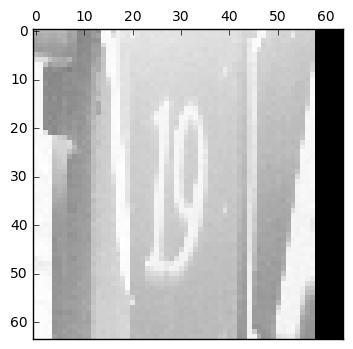

Should see [ 5. -1. -1. -1. -1.]


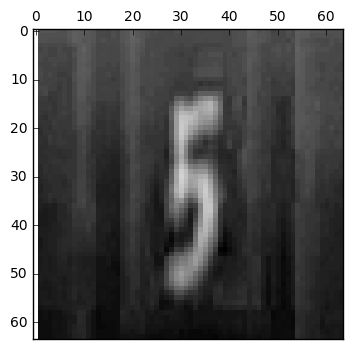

Should see [ 2.  3. -1. -1. -1.]


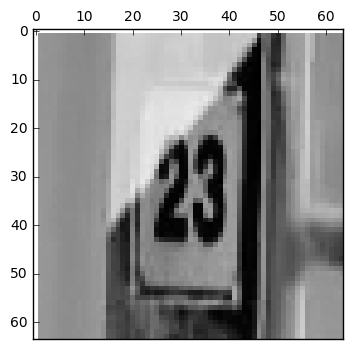

Should see [ 2.  1.  0. -1. -1.]


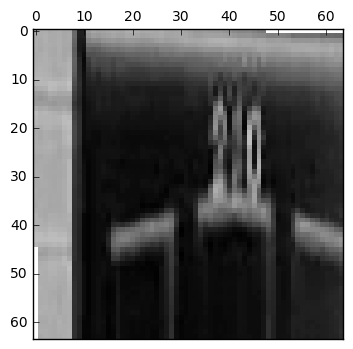

In [143]:
''' Data check '''
# Examine shapes and images
print('Shape of training images and labels:\t',
      train_svhn_images.shape, train_svhn_labels.shape)
print('Shape of test images and labels:\t',
      test_svhn_images.shape, test_svhn_labels.shape)

print()
for i in xrange(2):
    print('Should see', train_svhn_labels[i])
    show(train_svhn_images[i])
    
    print('Should see', test_svhn_labels[i])
    show(test_svhn_images[i])

Looking good so far. Now we need to normalize our image data (to 0-1 range), add an extra layer indicating depth, and one-hot encode the labels. We also need to separate out a validation set.

In [144]:
# Normalizing data...
pixel_max = float(train_svhn_images.max())

print("Original min and max:", train_svhn_images.min(), pixel_max)

train_svhn_images = train_svhn_images / pixel_max
test_svhn_images  = test_svhn_images  / pixel_max

# Check images are still legit:
print("New min and max:", train_svhn_images.min(), train_svhn_images.max())

Original min and max: 0 255.0
New min and max: 0.0 1.0


Before going on to splitting into final training, validation, and test sets, we'll examine the pixel distribution across the two sets:

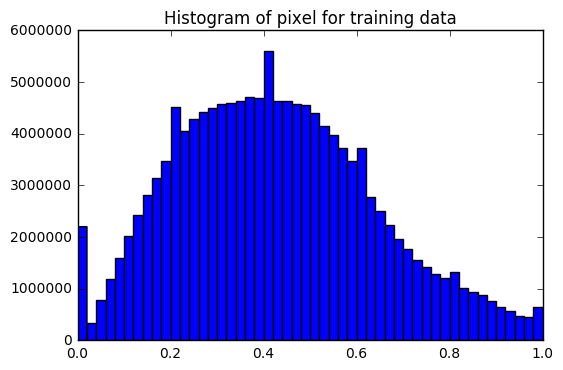

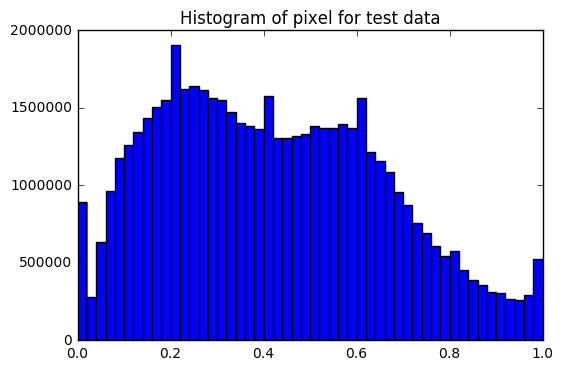

In [145]:
plt.hist(train_svhn_images.flatten(), 50)
plt.title('Histogram of pixel for training data')
plt.show()

plt.hist(test_svhn_images.flatten(), 50)
plt.title('Histogram of pixel for test data')
plt.show()

Although similar, the distributions are slightly different. Notably, the test data is bimodal, with these modes surrounding the mode of the training data. One way to handle this will be to swap half of the test set with training data.

Pre swap:
Training image: [ 1.  9. -1. -1. -1.]


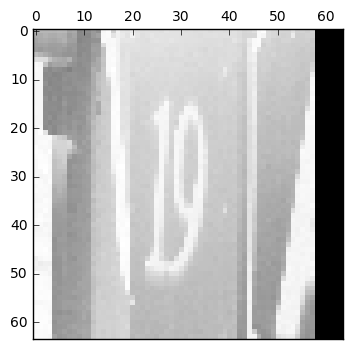

Test image: [ 5. -1. -1. -1. -1.]


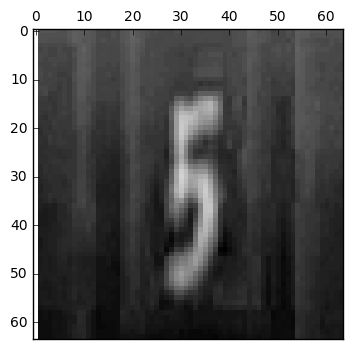

Post swap:
Training image: [ 5. -1. -1. -1. -1.]


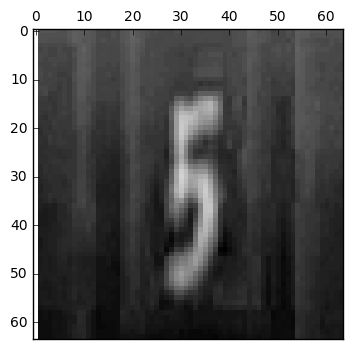

Test image: [ 1.  9. -1. -1. -1.]


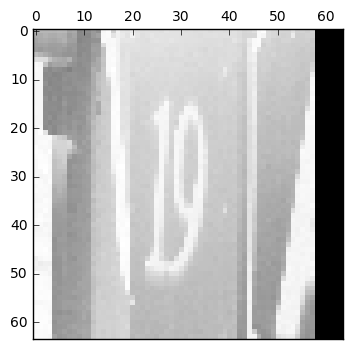

In [148]:
n_swap = test_svhn_labels.shape[0] / 2  # Number of test set images to swap

print('Pre swap:')
print('Training image:', train_svhn_labels[0])
show(train_svhn_images[0])
print('Test image:', test_svhn_labels[0])
show(test_svhn_images[0])

# We'll swap at the front
train_2swap_images = np.copy(train_svhn_images[:n_swap])
train_2swap_labels = np.copy(train_svhn_labels[:n_swap])
test_2swap_images  = np.copy(test_svhn_images[:n_swap])
test_2swap_labels  = np.copy(test_svhn_labels[:n_swap])

# Do swap
train_svhn_images[:n_swap] = test_2swap_images
train_svhn_labels[:n_swap] = test_2swap_labels
test_svhn_images[:n_swap]  = train_2swap_images
test_svhn_labels[:n_swap]  = train_2swap_labels

print('Post swap:')
print('Training image:', train_svhn_labels[0])
show(train_svhn_images[0])
print('Test image:', test_svhn_labels[0])
show(test_svhn_images[0])

After shuffling:
Training image: [ 8.  6. -1. -1. -1.]


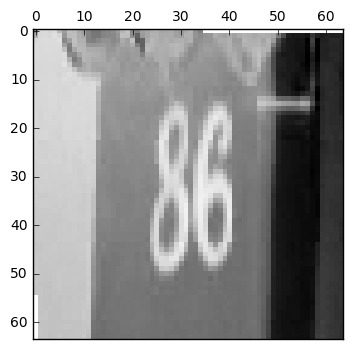

Test image: [ 6.  0. -1. -1. -1.]


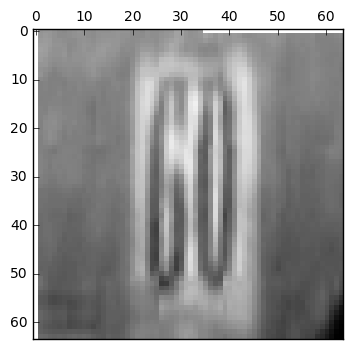

In [156]:
# SHUFFLE data sets!
train_indexes = np.array(xrange(train_svhn_labels.shape[0]))
test_indexes  = np.array(xrange(test_svhn_labels.shape[0]))

np.random.seed(8745)  # For replicable results
np.random.shuffle(train_indexes)
np.random.shuffle(test_indexes)

train_svhn_images = train_svhn_images[train_indexes]
train_svhn_labels = train_svhn_labels[train_indexes]
test_svhn_images  = test_svhn_images[test_indexes]
test_svhn_labels  = test_svhn_labels[test_indexes]

# Check:
print('After shuffling:')
print('Training image:', train_svhn_labels[0])
show(train_svhn_images[0])
print('Test image:', test_svhn_labels[0])
show(test_svhn_images[0])

Now we proceed to creating final train, validation, and test sets in appropriate format.

In [161]:
num_labels = 11  # -1 to 9
num_channels = 1 # grayscale
p_valid = 0.4    # Proportion of test set to be used for validation set

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, size[0], size[1], num_channels)).astype(np.float32)
    labels = ((np.arange(num_labels) - 1) == labels[:,:,None]).astype(np.float32)
    return dataset, labels

n_valid = int(test_svhn_labels.shape[0] * p_valid)

train_svhn, train_svhn_l = reformat(train_svhn_images, train_svhn_labels)
valid_svhn, valid_svhn_l = reformat(test_svhn_images[:n_valid], test_svhn_labels[:n_valid])
test_svhn, test_svhn_l   = reformat(test_svhn_images[n_valid:], test_svhn_labels[n_valid:])

print('Training set', train_svhn.shape, train_svhn_l.shape)
print('Validation set', valid_svhn.shape, valid_svhn_l.shape)
print('Test set', test_svhn.shape, test_svhn_l.shape)

Training set (33401, 64, 64, 1) (33401, 5, 11)
Validation set (5227, 64, 64, 1) (5227, 5, 11)
Test set (7841, 64, 64, 1) (7841, 5, 11)


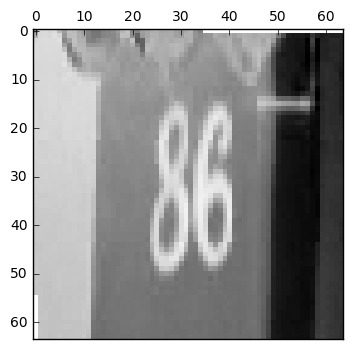

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


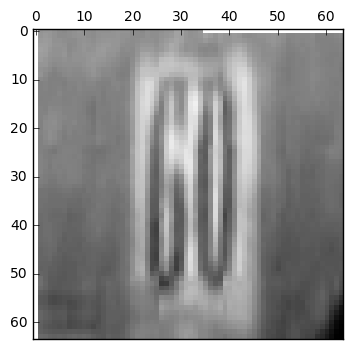

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


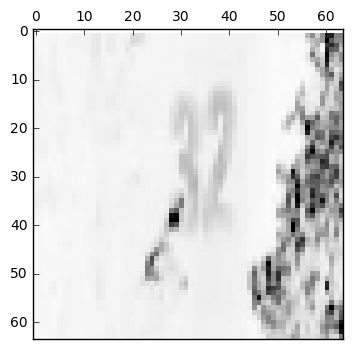

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [162]:
# Checking one-hot encoding
show(np.squeeze(train_svhn, axis=(3,))[0])
print(train_svhn_l[0])

show(np.squeeze(valid_svhn, axis=(3,))[0])
print(valid_svhn_l[0])

show(np.squeeze(test_svhn, axis=(3,))[0])
print(test_svhn_l[0])

## We're now ready to train our model!

In [163]:
# Function to determine prediction accuracy
def accuracy(predictions, labels):
    return(100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))
          / predictions.shape[0] / predictions.shape[1])

In [164]:
batch_size = 128
patch_size = 5

# Conv depths...
depth1 = 16
depth2 = 32
depth3 = 64

# Hidden depths...
n_hidden1 = 128
n_hidden2 = 64

graph = tf.Graph()

with graph.as_default():
    
    # Input data -----------------------
    tf_train = tf.placeholder(
        tf.float32, shape = (batch_size, size[0], size[1], num_channels)
    )
    tf_train_l = tf.placeholder(
        tf.float32, shape = (batch_size, svhn_max_digits, num_labels)
    )
    tf_valid = tf.constant(valid_svhn)
    tf_test  = tf.constant(test_svhn)
    
    # Net parameters -----------------------
    
    # Convolution layers
    c1_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev = 0.05)
    )
    c1_b = tf.Variable(
        tf.zeros([depth1])
    )
    c2_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev = 0.05)
    )
    c2_b = tf.Variable(
        tf.constant(1.0, shape = [depth2])
    )
    c3_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev = 0.05)
    )
    c3_b = tf.Variable(
        tf.constant(1.0, shape = [depth3])
    )
    # Fully connected layers
    f1_w = tf.Variable(
        tf.truncated_normal([depth3, n_hidden1], stddev = 0.05)
    )
    f1_b = tf.constant(1.0, shape = [n_hidden1])
    f2_w = tf.Variable(
        tf.truncated_normal([n_hidden1, n_hidden2], stddev = 0.05)
    )
    f2_b = tf.constant(1.0, shape = [n_hidden2])
    
    
    # Logistic classifier layers (one for each digit)
    s1_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s1_b = tf.constant(1.0, shape = [num_labels])
    s2_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s2_b = tf.constant(1.0, shape = [num_labels])
    s3_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s3_b = tf.constant(1.0, shape = [num_labels])
    s4_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s4_b = tf.constant(1.0, shape = [num_labels])
    s5_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s5_b = tf.constant(1.0, shape = [num_labels])
    
    # Model ----------------------
    
    # Convolution wrapper
    def conv2d(X, W, b):
        conv = tf.nn.conv2d(X, W, strides = [1, 2, 2, 1], padding = 'SAME') + b
        # Order (1) pool then (2) hidden reduces computation requirements and speeds learning
        pool = tf.nn.max_pool(conv, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        hidden = tf.nn.relu(pool)
        return hidden
    
    # Model
    def model(data, keep_prob = 1):
        # Convolution layers
        x = conv2d(data, c1_w, c1_b)
        x = conv2d(x,    c2_w, c2_b)
        x = conv2d(x,    c3_w, c3_b)
        
        # Fully connected
        shape = x.get_shape().as_list()
        reshape = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        reshape = tf.nn.dropout(reshape, keep_prob)  # Additional dropout
        x = tf.nn.relu(tf.matmul(reshape, f1_w) + f1_b)
        x = tf.nn.relu(tf.matmul(x, f2_w) + f2_b)
        x = tf.nn.dropout(x, keep_prob)
        
        # Logistic classifiers for each digit
        logit1 = tf.matmul(x, s1_w) + s1_b
        logit2 = tf.matmul(x, s2_w) + s2_b
        logit3 = tf.matmul(x, s3_w) + s3_b
        logit4 = tf.matmul(x, s4_w) + s4_b
        logit5 = tf.matmul(x, s5_w) + s5_b
        
        # Combine predictions to match 2D encoding
        # Note. if using sparse_... need pack([]), but not `axis=1`
        pred = tf.pack([logit1, logit2, logit3, logit4, logit5], axis=1)
        print(pred)
        return(pred)

    # Run --------------------------
    # If model seems to be overfitting, look at:
    # l1 and l2 regularisers; batch normalization
    
    logits = model(tf_train, 0.50)  # Try not to exceed .50
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 0, :], tf_train_l[:, 0])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 1, :], tf_train_l[:, 1])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 2, :], tf_train_l[:, 2])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 3, :], tf_train_l[:, 3])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 4, :], tf_train_l[:, 4]))
    
    # Adam optimizer (has a self adjusting learning rate)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    train_pred = tf.nn.softmax(logits)
    valid_pred = tf.nn.softmax(model(tf_valid))
    test_pred  = tf.nn.softmax(model(tf_test))

Tensor("pack:0", shape=(128, 5, 11), dtype=float32)
Tensor("pack_1:0", shape=(5227, 5, 11), dtype=float32)
Tensor("pack_2:0", shape=(7841, 5, 11), dtype=float32)


In [165]:
""" Run the graph """
num_steps = 1000001
start_time = time.time()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Intialized\n")
    
    for step in range(num_steps):
        offset  = (step * batch_size) % (train_svhn_l.shape[0] - batch_size)
        batch   = train_svhn[offset:(offset + batch_size), :, :, :]
        batch_l = train_svhn_l[offset:(offset + batch_size), :]
        feed_dict = {
            tf_train   : batch,
            tf_train_l : batch_l
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_pred], feed_dict = feed_dict
        )
        
        if (step % 500 == 0):
            print('--- Step %d ---' % (step))
            print('Time elapsed: %.1f seconds' % (time.time() - start_time))
            print('Minibatch loss: %f' % (l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_l))
            print('Validation accuracy: %.1f%%' % accuracy(valid_pred.eval(), valid_svhn_l))
            print()
    
    print('--- Test ---')
    print('Test accuracy: %.1f%%' % accuracy(test_pred.eval(), test_svhn_l))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Intialized

--- Step 0 ---
Time elapsed: 2.9 seconds
Minibatch loss: 13.854076
Minibatch accuracy: 3.4%
Validation accuracy: 4.4%

--- Step 500 ---
Time elapsed: 57.1 seconds
Minibatch loss: 6.666148
Minibatch accuracy: 59.2%
Validation accuracy: 63.5%

--- Step 1000 ---
Time elapsed: 108.7 seconds
Minibatch loss: 6.061164
Minibatch accuracy: 60.2%
Validation accuracy: 63.5%

--- Step 1500 ---
Time elapsed: 160.4 seconds
Minibatch loss: 5.924541
Minibatch accuracy: 62.0%
Validation accuracy: 63.5%

--- Step 2000 ---
Time elapsed: 212.0 seconds
Minibatch loss: 5.766835
Minibatch accuracy: 64.2%
Validation accuracy: 63.5%

--- Step 2500 ---
Time elapsed: 263.7 seconds
Minibatch loss: 6.092793
Minibatch accuracy: 60.8%
Validation accuracy: 63.5%

--- Step 3000 ---
Time elapsed: 315.6 seconds
Minibatch loss: 5.921661
Minibatch accuracy: 63.0%
Validation accuracy: 63.5%

--- Step 3500 ---
Time elapsed: 367.4 seconds
M

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I converted all images to grayscale and resized then to a 64 x 64 pixel image.

The model performance is above chance, but not great. For example, the final test accuracy of 71.4% can be compared to 97.84% found by Goodfellow et al., (2013; https://arxiv.org/pdf/1312.6082.pdf). However, Goodfellow et al., preprocessed the data by explicitly extracting digits from their bounding boxes. Here, the algorithm was not afforded this luxury, making it a considerably more challenging problem.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

Most changes were made in the preprocessing stage. For example, converting to grayscale and resizing to 64 x 64 helped reduce time (which was an important factor given the model was run on a home computer).

Certain changes led to poorer results. For example, I attempted to boost the number of images that had 4 or 5 digits by creating many distorted versions of the existing images. This resulted in practically no learning.

In the end, I shuffled the training and test data sets because they had slightly different pixel distributions. During my first attempt (without shuffling), I was able to achieve training accuracy of ~85%. However, the model appeared to be overfitting, as the validation and test accuracy never increase beyond ~60%.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

As mentioned above, my first model had a test accuracy of about 60%. The final model used above had 71.4%. This is an certainly an improvement, but not fantastic.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.